대부분의 머신러닝 애플리케이션은 하나의 알고리즘으로 이뤄져 있지 않고, 여러 단계의 처리 과정과 머신러닝 모델이 연결되어 있다.

데이터 변환 과정과 머신러닝 모델을 쉽게 연결해주는 Pipeline 파이썬 클래스에 대해 알아보자.

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm=SVC()
svm.fit(X_train_scaled, y_train)

print("Test Score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test Score: 0.95


# 6.1 데이터 전처리와 매개변수 선택

In [10]:
#GridSearchCV를 사용해서 더 좋은 SVC 매개변수를 찾아보자.
from sklearn.model_selection import GridSearchCV
#예를 위한 코드이니 실제로 사용하지 말것.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print('최상의 교차 검증 정확도 : {:.2f}'.format(grid.best_score_))
print('Test Score: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('Best Parameter: ', grid.best_params_)

최상의 교차 검증 정확도 : 0.98
Test Score: 0.97
Best Parameter:  {'C': 1, 'gamma': 1}


여기에서 알아두어야 하는 것은, 우리가 MinMaxSclaer를 사용했을 때 훈련 세트에 있는 모든 데이터를 사용하였다는 것이다.  
그런 다음에 스케일이 조정된 훈련 데이터에서 교차 검증을 사용해 그리도 서치를 수행했다.  
교차 검증을 할 때에 검증 폴드는 훈련 폴드로 학습된 모델이 새로운 데이터에 적용될 때의 성능을 측정하는 데 사용한다.  
그러나 데이터 스케일을 조정할 때 검증 폴드에 들어 있는 정보까지 이미 사용해버렸다..!  
실제로 새로운 데이터가 모델에 나타날 때는 이와 완전히 다르다.   
새로운 데이터가 관측되면 이 데이터는 훈련 데이터의 스케일 조정에 사용되지 않은 것이라, 그 최솟값과 최댓값이 훈련데이터와 다를 수 있다. 

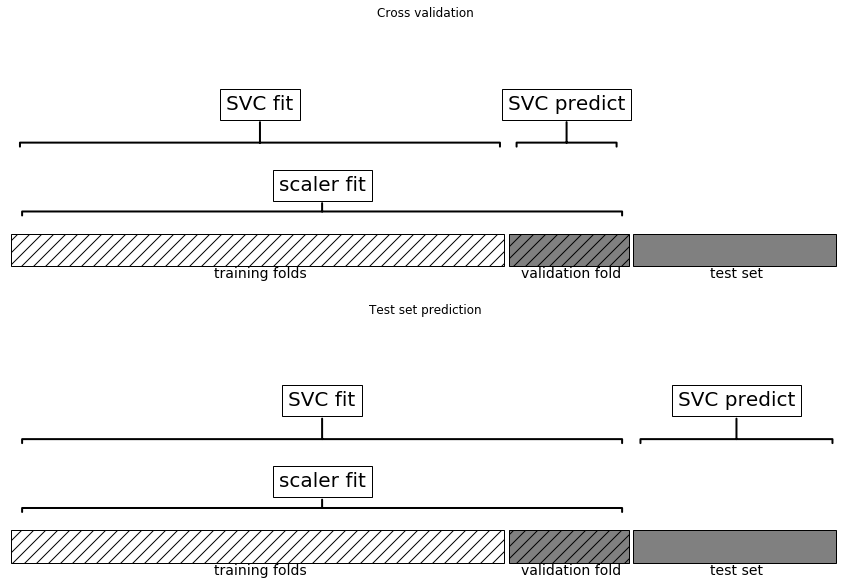

In [12]:
#교차 검증 동안 데이터 처리와 최종 평가가 어떻게 다른지 확인해보자
import mglearn
mglearn.plots.plot_improper_processing()

때문에 교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때를 올바로 반영하지 못하고 있다.  
검증 폴드 데이터의 정보가 모델 구축 과정에 이미 누설되었으므로 교차 검증에서 최적의 매개변수를 찾지 못하고 낙관적인 결과가 만들어지게 된다. 

이 문제를 해결하려면 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄져야 한다.  
데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 **'훈련 부분에만'** 적용되어야 하므로 교차 검증 반복 안에 있어야 한다.

Pipeline으로 구현하기 : 주로 분류기 같은 지도 학습 모델과 (데이터 스케일 조정 같은) 전처리 단계를 연결할 때 사용한다.

# 6.2 파이프라인 구축하기

In [14]:
#먼저 각 단계를 리스트로 전달하여 파이프라인 객체를 만든다.
##각 단계는 추정기의 객체와 임의의 이름으로 구성된 튜플
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

pipe.fit(X_train, y_train) #첫 번째 단계 scaler의 fit 메서드를 호출하여 훈련 데이터를 변환하고, 변환된 데이터에 SVM모델을 훈련시킨다.

print('Test Score: {:.2f}'.format(pipe.score(X_test, y_test))) #scaler로 테스트 데이터를 변환하고, 변환된 데이터에 SVM모델의 score 메서드를 호출한다.


Test Score: 0.95


# 6.3 그리드 서치에 파이프라인 적용하기
탐색할 매개변수 그리드를 정의하고, 이 매개변수 그리드와 파이프라인으로 GridSearchCV의 객체를 만든다.
주의할 점은 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 알려줘야 한다. 
C와 gamma 매개변수는 두 번째 단계인 SVC의 매개변수 이므로 SVC의 이름인 'svm'과 '\_\_(밑줄문자 2개)'로 연결해 만든다.

In [15]:
param_grid = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid= param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('Test Score: {:.2f}'.format(grid.score(X_test, y_test)))
print('Best Parmeter: ', grid.best_params_)

최상의 교차 검증 정확도: 0.98
Test Score: 0.97
Best Parmeter:  {'svm__C': 1, 'svm__gamma': 1}


이전에 본 그리드 서치와 다른 점은 교차 검증의 각 분할에 MinMaxScaler가 훈련 폴드에 매번 적용되어, 매개변수 검색 과정에서 검증 폴드의 정보가 누설되지 않았다. 

# 6.4 파이프라인 인터페이스
Pipeline은 전처리나 분류에 국한하지 않고 어떤 추정기와도 연결할 수 있다. 예를들어 특성 추출, 특성 선택, 스케일 변경, 분류의 총 네 단계를 포함하는 파이프라인을 만들 수 있다.   
파이프라인에 들어갈 추정기는 마지막 단계를 제외하고는 모두 transform 메서드를 가지고 있어야 한다. 그래서 다음 단계를 위한 새로운 데이터 표현을 만들 수 있어야 한다.  
내부적으로는 Pipeline.fit 메서드가 실행되는 동안, 파이프라인은 각 단계에서 이전 단계의 transform의 출력을 입력으로 받아 fit과 transform 메서드를 차례로 호출한다. 그리고 마지막 단계는 fit 메서드만 호출한다.  

In [18]:
#세부사항을 구현해보기
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        #마지막 단계를 빼고 fit과 transform을 반복한다.
        X_transformed = estimator.fit_transform(X_transform, y)
    self.steps[-1][1].fit(X_transformed, y)
    #pipeline.steps는 튜플의 리스트라서 pipeline.steps[0][1]은 첫 번째 추정기이고 pipeline.steps[1][1]은 두 번째 추정기가 되는 식
    return self

In [19]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        #마지막 단계를 빼고 transform을 반복한다.
        X_transformed = step[1].transfomr(X_transformed)
    #마지막 단계 predict를 호출한다.
    return self.steps[-1][1].predict(X_transformed)

# 6.4.1 make_pipeline을 사용한 파이프라인 생성
make_pipeline 함수는 각 단계 이름에 해당 파이썬 클래스의 이름을 부여한 파이프라인을 만들어준다.

In [22]:
from sklearn.pipeline import make_pipeline
#표준적인 방법
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])
#간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100)) #steps 속성에 각 단계의 이름이 있다.

In [23]:
print('파이프라인 단계:\n', pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [24]:
#같은 파이썬 클래스를 여러 단계에서 사용하면 이름 뒤에 숫자가 추가로 붙는다.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('파이프라인 단계:\n', pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


# 6.4.2 단계 속성에 접근하기

In [25]:
#cancer 데이터셋에 앞서 만든 파이프라인을 적용한다.
pipe.fit(cancer.data)
#'pca' 단계의 두 개 주성분을 추출한다.
components = pipe.named_steps['pca'].components_
print('components.shape: ', components.shape)

components.shape:  (2, 30)


# 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기
파이프라인을 사용하는 주된 목적은 그리드 서치 때문이다.  
그래서 그리드 서치 안에 있는 파이프라인의 단계에 접근할 때가 많다.

In [28]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('최상의 모델:\n', grid.best_estimator_) #best_estimator_는 standardscaler와 logisticregression 두 단계를 가진 파이프라인.

최상의 모델:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [29]:
#logisticregression 단계에 접근하려면, 이전에 한 것처럼 파이프라인의 named_steps 속성을 사용한다.
print('LogisticRegression 단계:\n', grid.best_estimator_.named_steps['logisticregression'])

LogisticRegression 단계:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [30]:
print('LogisticRegression 회귀 계수:\n',
     grid.best_estimator_.named_steps['logisticregression'].coef_)

LogisticRegression 회귀 계수:
 [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


# 6.5 전처리와 모델의 매개변수를 위한 그리드 서치
파이프라인을 사용하면 머신러닝 워크플로에 필요한 모든 처리 단계를 하나의 scikit-learn 추정기로 캡슐화할 수 있다.  
또 다른 장점으로, 회귀와 분류 같은 지도 학습의 출력을 이용해서 전처리 매개변수를 조정할 수 있다.

In [31]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

boston =load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [32]:
#이상적으로 분류의 결과에 기초해서 degree 매개변수를 선택해야 한다.
##(다항식 차수가 얼마나 되어야 할지, 또는 다항식이나 교차항이 필요한지)
###파이프라인을 사용하면 Ridge의 alpha 매개변수와 함께 degree 매개변수를 탐색할 수 있다.
param_grid = {'polynomialfeatures__degree' : [1,2,3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

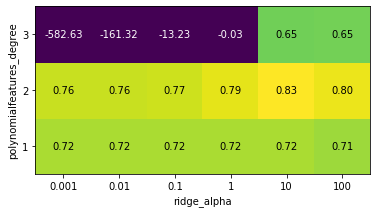

In [34]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                     xlabel='ridge_alpha', ylabel='polynomialfeatures_degree',
                     xticklabels = param_grid['ridge__alpha'],
                     yticklabels = param_grid['polynomialfeatures__degree'], vmin=0)
#2차항이 효과가 좋고 3차항은 1,2차보다 결과가 나쁘다. 

In [36]:
print('Best Parameter: ', grid.best_params_)
print('Test Score: {:.2f}'.format(grid.score(X_test, y_test)) )

Best Parameter:  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test Score: 0.77


In [37]:
#다항식 특성이 없는 그리드 서치와 비교
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('다항 특성 없을 때 점수 :{:.2f}'.format(grid.score(X_test, y_test)))

다항 특성 없을 때 점수 :0.63


# 6.6 모델 선택을 위한 그리드 서치
파이프라인을 구성하는 단계도 탐색 대상으로 삼을 수 있다(예를 들어 StandardScaler와 MinMaxScaler 중 어떤 것을 사용할지)  
그러나 이렇게 하면 탐색 범위가 더 넓어지므로 주의 깊게 고려해야 한다.

In [39]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('preprocessing', StandardScaler()),('classifier', SVC())])

#비대칭 매개변수 그리드 탐색
param_grid = [{'classifier' : [SVC()], 'preprocessing':[StandardScaler()],
              'classifier__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
              'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100]},
             {'classifier' : [RandomForestClassifier(n_estimators=100)],
             'preprocessing' :[None], 'classifier__max_features': [1,2,3]}]

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best Parmeter:\n{}\n'.format(grid.best_params_))
print('최상의 교차 검증 점수 : {:.2f}'.format(grid.best_score_))
print('Test Score: {:.2f}'.format(grid.score(X_test, y_test)))

Best Parmeter:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수 : 0.99
Test Score: 0.98


# 6.6.1 중복 계산 피하기

In [40]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory='cache_folder')